In [1]:
## Generating figures for poster

In [40]:
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib
import math

In [19]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

In [20]:
def initial_df_processing(name):
    
    df = pd.read_json('cleaned_events/'+name)
    
    # Merge the two databases together
    df = df.merge(players, how = 'left', on = 'playerId')
    
    # Let's clean it up a bit and get rid of some unnecessary info so we have just what we need
    df.drop(['passportArea', 'weight', 'firstName','middleName','lastName','currentTeamId',
         'birthDate','height','role','foot','currentNationalTeamId','birthArea','subEventId',
         'id','xStart', 'xEnd', 'yStart', 'yEnd', 'attackMetres'],inplace = True, axis = 1)
    
    return df

def event_handling(df):
    # Cleans things up based on our interpretation of the events and how they relate to passes. Note the meaning of
    # the events:
    # 1 - duels (this is a hard one to define as it means many different things)
    # 2 - fouls
    # 3 - free kicks / corners (hence we add a node so that it picks these up as the first play in the chain)
    # 4 - keeper leaving their line
    # 7 - Touch, acceletation or clearance (also vague- get rid of touch/acc but keep clearance if its accurate)
    # 8 - Pass - simple/smart, cross (main data we're after for this)
    # 9 - Reflexes / save (however if tagged as inaccurate it means there was a goal)
    # 10- Shot (add a shot node)
    
    df = df.loc[ df['eventId'] != 9]
    df = df.loc[ df['eventId'] != 1]
    df = df.loc[ df['eventId'] != 2]
    df = df.loc[ df['eventId'] != 4]
    df = df.loc[ df['eventId'] != 7]
    df = df.loc[ df['subEventName'] != 'Touch']
    df = df.loc[ df['subEventName'] != 'Acceleration']
    df = df.loc[ (df['subEventName'] != 'Clearance') | (df['Result'] == 'Inaccurate')]
    df = df.drop(df[(df.subEventName == 'Clearance') & (df.Result =='Inaccurate')].index)

    # Create some new columns to see where passes ended up etc
    df["next_event"] = df['eventId'].shift(-1)
    df["next_teamId"] = df["teamId"].shift(-1)
    df["next_player"] = df["shortName"].shift(-1)
    df.loc[ df["next_event"] == 3, 'next_player'] = 0.5
    df.loc[ df["eventId"] == 10, 'next_player'] = 0
    
    return df

def continuous_time(df):
    # Converts to a continuous 90 min (ie 90*60 = 5400 second) game
    firsthalf = df.loc[df['matchPeriod'] == '1H']
    first_half_length = list(firsthalf['eventSec'])[-1]
    df.loc[ df.matchPeriod == '2H' , 'eventSec'] += first_half_length
    
    #Take out extra time / penalties for the cup games
    df = df.loc[df['matchPeriod'] != 'E1']
    df = df.loc[df['matchPeriod'] != 'E2']
    df = df.loc[df['matchPeriod'] != 'P']
    
    return df

In [21]:
players = pd.read_json('Players.json')
players = players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [22]:
# Generate a passing network
df = initial_df_processing('cleaned_events_Spain.json')

df = df.loc[df['matchId'] == 2565711]

df = continuous_time(df)

df = event_handling(df)

In [23]:
def passeslist(df, teamIds):
    
    # Create a Passes column which only has successive events between the same team 
    df = df.drop( df[(df.teamId != df.next_teamId) & (df.next_player != 0)].index)
    df['Passes'] = list(zip(df['shortName'], df['next_player']))
    
    # Get a passes list for each team
    passes = []
    for team in teamIds:    
        temp = df.loc[df['teamId'] == team]
        passes.append(list(temp['Passes']))

    return passes[0], passes[1]

def weighted_passes(passes):
    # Builds a network for the team based on the passes as edges
    n = nx.DiGraph()
    for (i,j) in passes:
        if n.has_edge(i,j):
            n[i][j]['weight'] += 1
        else:
            n.add_edge(i,j, weight = 1)
    
    # Remove node 0.5 as only used to signify start of plays from free kicks / corners
    if 0.5 in n.nodes():
        n.remove_node(0.5)
        
    return n

In [24]:
df = df.loc[df['eventSec']<60*45]

In [25]:
pass1, pass2 = passeslist(df,list(set(df['teamId'])))

In [26]:
net1 = weighted_passes(pass1)
net2 = weighted_passes(pass2)

In [27]:
renaming = {'L. Su\\u00e1rez':'Suarez','Sergio Busquets':'Busquets','Piqu\\u00e9':'Pique','T. Vermaelen':'Vermaelen',
           'I. Rakiti\\u0107':'Rakitic','M. ter Stegen':'ter Stegen', 'Sergi Roberto':'Roberto','L. Messi':'Messi',
           'Paulinho':'Paulinho','Iniesta':'Iniesta',0:'Shot','N\\u00e9lson Semedo':'Semedo',
            'Andr\\u00e9 Gomes':'Gomes','Aleix Vidal':'Vidal'}

In [28]:
net2 = nx.relabel_nodes(net2,renaming)

In [29]:
list(net2.nodes())

['Suarez',
 'Busquets',
 'Pique',
 'Vermaelen',
 'Jordi Alba',
 'Rakitic',
 'ter Stegen',
 'Roberto',
 'Messi',
 'Paulinho',
 'Iniesta',
 'Shot']

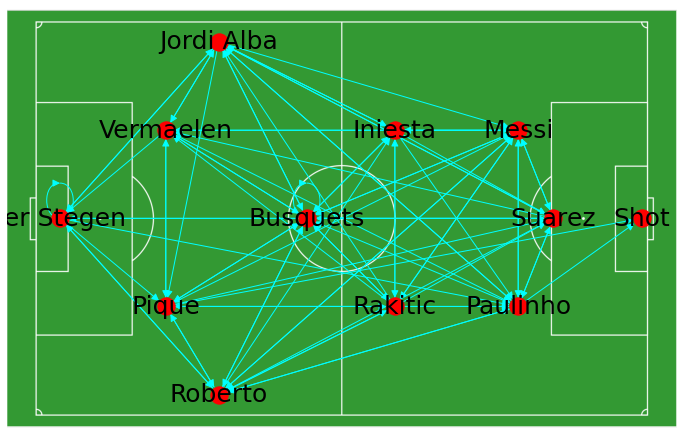

In [36]:
plt.figure(figsize = (12,8))
img = mpimg.imread('/Users/Yuval/Desktop/soccerpitch.png')
plt.imshow(img,alpha = 0.8,extent = [-2, 36, 18, 42])
nx.draw(net2, with_labels = True, pos = {'Suarez' : (29,30), 'Busquets': (15,30), 'Pique':(7,25), 'Vermaelen':(7,35),
                                         'Jordi Alba': (10,40), 'Rakitic': (20,25), 'ter Stegen':(1,30), 
                                         'Roberto':(10,20), 'Messi':(27,35),'Paulinho':(27,25), 'Iniesta':(20,35),
                                         'Shot':(34,30)}, node_color = 'red',edge_color = 'cyan',arrowsize = 15,
       font_size = 25)

In [31]:
list(net1.nodes())

['Casemiro',
 'K. Navas',
 'Sergio Ramos',
 'Cristiano Ronaldo',
 'T. Kroos',
 'Daniel Carvajal',
 'R. Varane',
 'L. Modri\\u0107',
 'Marcelo',
 0,
 'M. Kova\\u010di\\u0107',
 'K. Benzema']

In [32]:
rename_madrid = {'L. Modri\\u0107':'Modric','Marco Asensio':'Asensio','K. Benzema':'Benzema','G. Bale':'Bale',
                 'T. Kroos':'Kroos','Lucas V\\u00e1zquez':'Vazquez','M. Kova\\u010di\\u0107':'Kovacic',
                 'R. Varane':'Varane','Sergio Ramos':'Ramos','K. Navas':'Navas','Cristiano Ronaldo':'Ronaldo',
                'Daniel Carvajal':'Carvajal',0:'Shot'}

In [33]:
net1 = nx.relabel_nodes(net1,rename_madrid)

In [34]:
net1.nodes()

NodeView(('Casemiro', 'Navas', 'Ramos', 'Ronaldo', 'Kroos', 'Carvajal', 'Varane', 'Modric', 'Marcelo', 'Shot', 'Kovacic', 'Benzema'))

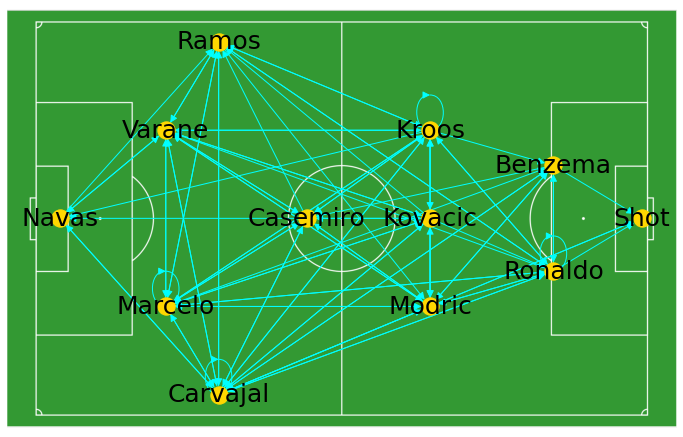

In [35]:
plt.figure(figsize = (12,8))
img = mpimg.imread('/Users/Yuval/Desktop/soccerpitch.png')
plt.imshow(img,alpha = 0.8,extent = [-2, 36, 18, 42])
nx.draw(net1, with_labels = True, pos = {'Kovacic' : (22,30), 'Casemiro': (15,30), 'Marcelo':(7,25), 'Varane':(7,35),
                                         'Ramos': (10,40), 'Modric': (22,25), 'Navas':(1,30), 
                                         'Carvajal':(10,20), 'Benzema':(29,33),'Ronaldo':(29,27), 'Kroos':(22,35),
                                         'Shot':(34,30)}, node_color = 'gold',edge_color = 'cyan',arrowsize = 15,
       font_size = 25)

In [1]:
# Entropy timeseries

In [37]:
def find_entropy(net,match,team):
    # This function attempts to calculate a team's entropy- i.e. their unpredictability.
    
    n = net
    n = nx.relabel_nodes(n, {0:'ZZ'})
    
    # A stochastic graph gives the probabilities of connections between certain platers       
    prob = nx.stochastic_graph(n)
    
    # Allows us to sort nodes alphabetically so that we can easily remove shot node later
    playerlist = sorted(list(n.nodes()))
    
    # Generates transition matrix
    probmat = nx.adjacency_matrix(prob, nodelist = playerlist)
    probmat = probmat.todense()
    matrix = np.array(probmat) # turns it into numpy array so that we can operate on it

    #entnode =  np.apply_along_axis( entropy, axis=1, arr = matrix ) # calculates entropy for each node
    
    entnode = []
    for row in matrix:
        e = 0
        for item in row:
            if item >0:
                e -= item * math.log10(item)
        entnode.append(e)

    entnode = entnode[:-1] # Gets rid of entropy of shot node
    
    matchid = []
    teamid = []
    for i in range(len(entnode)):
        matchid.append(match)
        teamid.append(team)

    entrop = sum(entnode)/len(n.nodes()) # Gets the average
        
    return entrop

In [38]:
# Generate a passing network
df = initial_df_processing('cleaned_events_Spain.json')

df = df.loc[df['matchId'] == 2565711]

df = continuous_time(df)

df = event_handling(df)

In [41]:
ents1 = []
ents2 = []
time = []

for i in range(0,85*60,30):
    
    time.append((i + 300)/60)
    
    temp_df = df.loc[df['eventSec'] > i]
    temp_df = temp_df.loc[df['eventSec'] < i+600]
    
    teams = sorted(list(set(temp_df['teamId'])))
    
    pass1, pass2 = passeslist(temp_df,teams)
    net1 = weighted_passes(pass1)
    net2 = weighted_passes(pass2)
    
    ent1 = find_entropy(net1,2565711,teams[0])
    ent2 = find_entropy(net2,2565711,teams[1])
    
    ents1.append(ent1)
    ents2.append(ent2)

In [42]:
teams

[675, 676]

In [43]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

(0.0, 92.0)

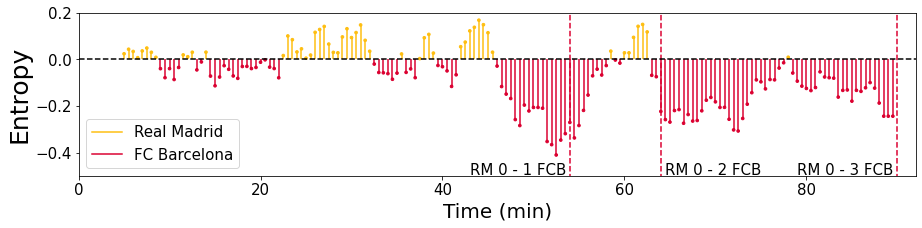

In [66]:
plt.figure(figsize = (15,3))
matplotlib.rcParams.update({'font.size': 15})
#plt.plot(time,diffs, c = my_color, label = 'Entropy')
#plt.plot(time,ents1,c = '#FEBE10',label = 'Real Madrid')
#plt.plot(time,ents2, c= '#DB0030', label = 'FC Barcelona')
#plt.plot([10]*61,[0.6-i/100 for i in range(61)],linestyle = 'dashed', c = '#DB0030')
#plt.plot([52]*61,[0.6-i/100 for i in range(61)],linestyle = 'dashed', c = '#DB0030')
#plt.plot([14]*61,[0.6-i/100 for i in range(61)],linestyle = 'dashed', c = '#FEBE10')
#plt.plot([72]*61,[0.6-i/100 for i in range(61)],linestyle = 'dashed', c = '#FEBE10')
# Create a color if the y axis value is equal or greater than 0
dif = np.array([ents1[i] - ents2[i] for i in range(len(ents1))])
my_color = np.where(dif>=0, '#FEBE10', '#DB0030')
plt.vlines(x=time, ymin=0, ymax=dif, color=my_color)
plt.scatter(time, dif, color=my_color, s=7, alpha=1)
plt.plot([54]*61,[0.5-i/60 for i in range(61)],linestyle = 'dashed', c = '#DB0030')
plt.plot([64]*61,[0.5-i/60 for i in range(61)],linestyle = 'dashed', c = '#DB0030')
plt.plot([90]*61,[0.5-i/60 for i in range(61)],linestyle = 'dashed', c = '#DB0030')
plt.xlabel('Time (min)', fontsize = 20)
plt.ylabel('Entropy',fontsize = 25)
plt.text(43,-0.495,'RM 0 - 1 FCB',fontsize = 15)
plt.text(64.5,-0.495,'RM 0 - 2 FCB',fontsize = 15)
plt.text(79,-0.495,'RM 0 - 3 FCB',fontsize = 15)
plt.plot([0,92],[0,0], c = 'black', linestyle = 'dashed')
# Not an actual plot- just add them for the legend
plt.plot([0,0],[0,0],color = '#FEBE10',label = 'Real Madrid')
plt.plot([0,0],[0,0],color = '#DB0030',label = 'FC Barcelona')
plt.legend()
plt.ylim(-0.5,0.2)
plt.xlim(0,92)

In [55]:
# Betweenness

In [56]:
def find_betweenness(net):
    
    n = net

    bet = nx.betweenness_centrality(n, normalized = False, weight = 'weight') #Just uses nx built ins. # weight?

    # Gets mean of all betweenness values. Shot node will have 0 anyway - it'll never be on the shortest 
    # path.
    betweenness = sum( list( bet.values() ) )/11
    
    return betweenness

In [57]:
# Generate a passing network
df = initial_df_processing('cleaned_events_Spain.json')

df = df.loc[df['matchId'] == 2565711]

df = continuous_time(df)

df = event_handling(df)

In [58]:
bets1 = []
bets2 = []
time = []

for i in range(0,85*60,30):
    
    time.append((i + 300)/60)
    
    temp_df = df.loc[df['eventSec'] > i]
    temp_df = temp_df.loc[df['eventSec'] < i+600]
    
    teams = sorted(list(set(temp_df['teamId'])))
    
    pass1, pass2 = passeslist(temp_df,teams)
    net1 = weighted_passes(pass1)
    net2 = weighted_passes(pass2)
    
    bet1 = find_betweenness(net1)
    bet2 = find_betweenness(net2)
    
    bets1.append(bet1)
    bets2.append(bet2)

In [59]:
bet_dif = [bets1[i] - bets2[i] for i in range(len(bets1))]
bet_dif = np.array(bet_dif)

In [60]:
teams

[675, 676]

(-1.0, 1.2)

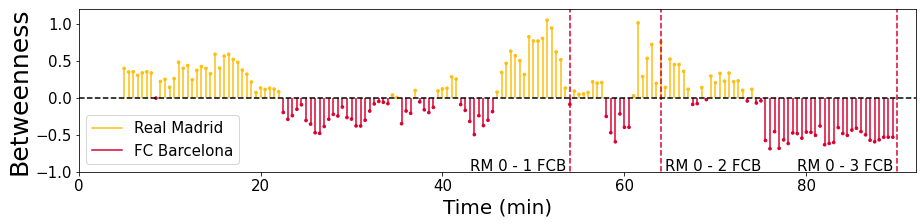

In [65]:
plt.figure(figsize = (15,3))
matplotlib.rcParams.update({'font.size': 15})
my_color = np.where(bet_dif>=0, '#FEBE10', '#DB0030')
plt.vlines(x=time, ymin=0, ymax=bet_dif/11, color=my_color)
plt.scatter(time, bet_dif/11, color=my_color, s=7, alpha=1)
plt.plot([54,54],[20,-20],linestyle = 'dashed', c = '#DB0030')
plt.plot([64,64],[20,-20],linestyle = 'dashed', c = '#DB0030')
plt.plot([90,90],[20,-20],linestyle = 'dashed', c = '#DB0030')
plt.xlabel('Time (min)', fontsize = 20)
plt.ylabel('Betweenness',fontsize = 25)
plt.text(43,-0.98,'RM 0 - 1 FCB',fontsize = 15)
plt.text(64.5,-0.98,'RM 0 - 2 FCB',fontsize = 15)
plt.text(79,-0.98,'RM 0 - 3 FCB',fontsize = 15)
plt.plot([0,92],[0,0], c = 'black', linestyle = 'dashed')
# Not an actual plot- just add them for the legend
plt.plot([0,0],[0,0],color = '#FEBE10',label = 'Real Madrid')
plt.plot([0,0],[0,0],color = '#DB0030',label = 'FC Barcelona')
plt.legend()
plt.xlim(0,92)
plt.ylim(-1,1.2)

In [67]:
# Closeness
def find_closeness(net):
    
    n = net

    out_close = nx.algorithms.centrality.closeness_centrality(n.reverse())
    in_close  = nx.algorithms.centrality.closeness_centrality(n)
    # The closeness centrality uses inward distance to a node, not outward. If you want to use outword 
    # distances apply the function to G.reverse(). We want both, with equal weighting, so we add them up.
    close =  np.mean( sum(list( out_close.values() ))/11 + sum(list(in_close.values()))/11 )
    
    return close

In [68]:
# Generate a passing network
df = initial_df_processing('cleaned_events_Spain.json')

df = df.loc[df['matchId'] == 2565711]

df = continuous_time(df)

df = event_handling(df)

In [69]:
clos1 = []
clos2 = []
time = []

for i in range(0,85*60,30):
    
    time.append((i + 300)/60)
    
    temp_df = df.loc[df['eventSec'] > i]
    temp_df = temp_df.loc[df['eventSec'] < i+600]
    
    teams = sorted(list(set(temp_df['teamId'])))
    
    pass1, pass2 = passeslist(temp_df,teams)
    net1 = weighted_passes(pass1)
    net2 = weighted_passes(pass2)
    
    clo1 = find_closeness(net1)
    clo2 = find_closeness(net2)
    
    clos1.append(clo1)
    clos2.append(clo2)

In [70]:
clo_dif = [clos1[i] - clos2[i] for i in range(len(bets1))]
clo_dif = np.array(clo_dif)

(-0.75, 0.4)

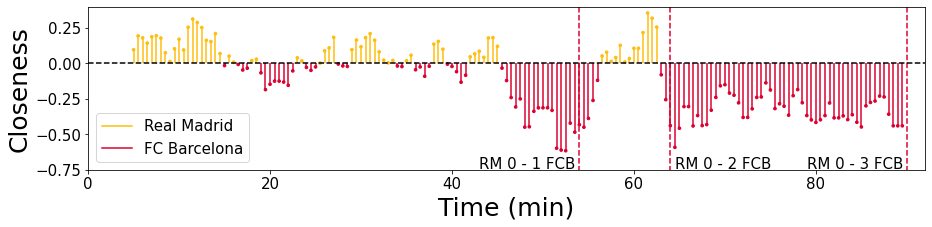

In [72]:
plt.figure(figsize = (15,3))
matplotlib.rcParams.update({'font.size': 15})
my_color = np.where(clo_dif>=0, '#FEBE10', '#DB0030')
plt.vlines(x=time, ymin=0, ymax=clo_dif, color=my_color)
plt.scatter(time, clo_dif, color=my_color, s=7, alpha=1)
plt.plot([54,54],[20,-20],linestyle = 'dashed', c = '#DB0030')
plt.plot([64,64],[20,-20],linestyle = 'dashed', c = '#DB0030')
plt.plot([90,90],[20,-20],linestyle = 'dashed', c = '#DB0030')
plt.xlabel('Time (min)', fontsize = 25)
plt.ylabel('Closeness',fontsize = 25)
plt.text(43,-0.74,'RM 0 - 1 FCB',fontsize = 15)
plt.text(64.5,-0.74,'RM 0 - 2 FCB',fontsize = 15)
plt.text(79,-0.74,'RM 0 - 3 FCB',fontsize = 15)
plt.plot([0,92],[0,0], c = 'black', linestyle = 'dashed')
# Not an actual plot- just add them for the legend
plt.plot([0,0],[0,0],color = '#FEBE10',label = 'Real Madrid')
plt.plot([0,0],[0,0],color = '#DB0030',label = 'FC Barcelona')
plt.legend()
plt.xlim(0,92)
plt.ylim(-0.75, 0.4)

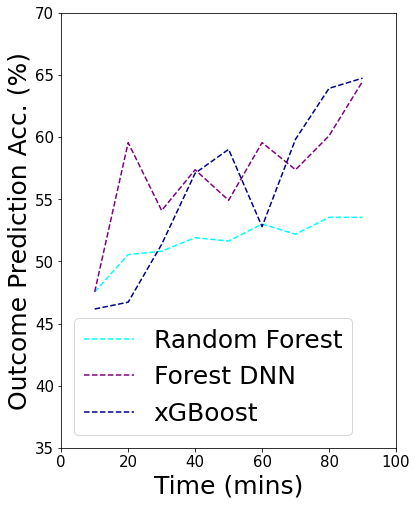

In [81]:
## Jordan's match prediction outcomes
rf = []
fdnn = []
xb = []
accuracies = [47.54, 47.55, 46.17, 50.55, 59.56, 46.72, 50.82, 54.10, 51.37, 51.91, 57.377, 57.10, 51.64, 54.92, 59.02, 53.01, 59.56, 52.8, 52.19, 57.38, 59.84, 53.55, 60.11, 63.93, 53.55, 64.481, 64.75]
for i in range(0,27,3):
    rf.append(accuracies[i])
    fdnn.append(accuracies[i+1])
    xb.append(accuracies[i+2])
    
minutes = [10,20,30,40,50,60,70,80,90]

plt.figure(figsize = (6,8))
plt.plot(minutes,rf, label = 'Random Forest', color = 'cyan', linestyle = 'dashed')#color = (0.387,0.18,0.434))
plt.plot(minutes,fdnn, label = 'Forest DNN',color = 'purple', linestyle = 'dashed') #color = (0.226,0.279,0.495))
plt.plot(minutes,xb, label = 'xGBoost', color = 'darkblue', linestyle = 'dashed')#color = (0.222,0.391,0.387))
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)', fontsize = 25)
plt.ylabel('Outcome Prediction Acc. (%)', fontsize = 25)
plt.legend(fontsize = 25)

In [5]:
## Match prediction from multivariate time series
tsf = [0.4418604651162791, 0.4625322997416021, 0.4935400516795866, 0.4780361757105943, 0.4702842377260982, 0.5012919896640827, 0.5167958656330749, 0.537467700258398]
skt = [0.42118863049095606, 0.46770025839793283, 0.4573643410852713, 0.4573643410852713, 0.4754521963824289, 0.49870801033591733, 0.5193798449612403, 0.5400516795865633]
roc = [0.4082687338501292, 0.37467700258397935, 0.4160206718346253, 0.43410852713178294, 0.4315245478036176, 0.4728682170542636, 0.4573643410852713, 0.5038759689922481]

def make_percent(listt):
    l = [i*100 for i in listt]
    return l
        
tsf = make_percent(tsf)
skt = make_percent(skt)
roc = make_percent(roc)


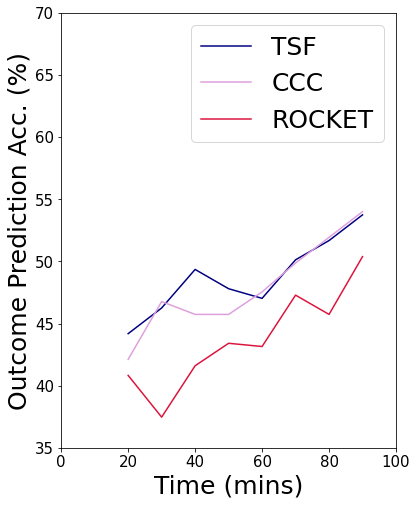

In [80]:
plt.figure(figsize = (6,8))
plt.plot(minutes[1:],tsf, label = 'TSF', color = 'navy')#color = (0.387,0.18,0.434))
plt.plot(minutes[1:],skt, label = 'CCC',color = 'plum') #color = (0.226,0.279,0.495))
plt.plot(minutes[1:],roc, label = 'ROCKET', color = 'crimson')#color = (0.222,0.391,0.387))
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)',fontsize = 25)
plt.ylabel('Outcome Prediction Acc. (%)', fontsize = 25)
plt.legend(fontsize = 25)

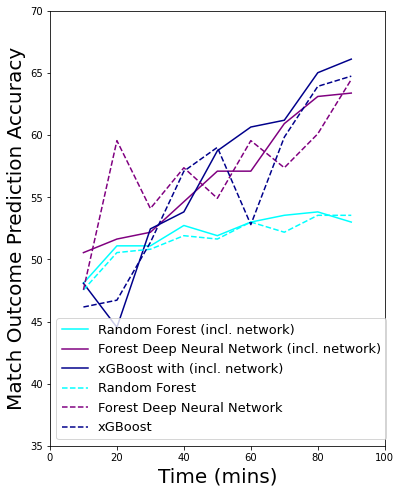

In [7]:
## Combined features with network metrics
rf = [0.4808743169398907, 0.5109289617486339, 0.5109289617486339, 0.5273224043715847, 0.5191256830601093, 0.5300546448087432, 0.5355191256830601, 0.5382513661202186, 0.5300546448087432] 
fdnn = [0.505464494228363, 0.5163934230804443, 0.5218579173088074, 0.5464481115341187, 0.5710382461547852, 0.5710382461547852, 0.6092896461486816, 0.631147563457489, 0.6338797807693481] 
xg = [0.4808743169398907, 0.4453551912568306, 0.5245901639344263, 0.5382513661202186, 0.587431693989071, 0.6065573770491803, 0.6120218579234973, 0.6502732240437158, 0.6612021857923497]

rf = make_percent(rf)
fdnn = make_percent(fdnn)
xg = make_percent(xg)

old_rf = []
old_fdnn = []
old_xb = []
accuracies = [47.54, 47.55, 46.17, 50.55, 59.56, 46.72, 50.82, 54.10, 51.37, 51.91, 57.377, 57.10, 51.64, 54.92, 59.02, 53.01, 59.56, 52.8, 52.19, 57.38, 59.84, 53.55, 60.11, 63.93, 53.55, 64.481, 64.75]
for i in range(0,27,3):
    old_rf.append(accuracies[i])
    old_fdnn.append(accuracies[i+1])
    old_xb.append(accuracies[i+2])


plt.figure(figsize = (6,8))
plt.plot(minutes,rf, label = 'Random Forest (incl. network)', color = 'cyan')#color = (0.387,0.18,0.434))
plt.plot(minutes,fdnn, label = 'Forest Deep Neural Network (incl. network)',color = 'purple') #color = (0.226,0.279,0.495))
plt.plot(minutes,xg, label = 'xGBoost with (incl. network)', color = 'darkblue')#color = (0.222,0.391,0.387))
plt.plot(minutes,old_rf, label = 'Random Forest', color = 'cyan', linestyle = 'dashed')#color = (0.387,0.18,0.434))
plt.plot(minutes,old_fdnn, label = 'Forest Deep Neural Network',color = 'purple', linestyle = 'dashed') #color = (0.226,0.279,0.495))
plt.plot(minutes,old_xb, label = 'xGBoost', color = 'darkblue', linestyle = 'dashed')#color = (0.222,0.391,0.387))
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)', fontsize = 20)
plt.ylabel('Match Outcome Prediction Accuracy', fontsize = 20)
plt.legend(fontsize = 13)



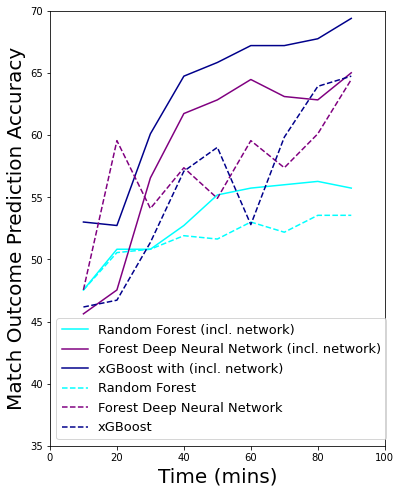

In [8]:
## New and improved match prediction
rf = [47.54,50.82,50.82,52.73,55.19,55.74,56.01,56.28,55.74]
fdnn = [45.62,47.54,56.56,61.74,62.84,64.48, 63.11,62.84,65.02]
xg = [53.01,52.73,60.11,64.75,65.85,67.21,67.21,67.76,69.40]

old_rf = []
old_fdnn = []
old_xb = []
accuracies = [47.54, 47.55, 46.17, 50.55, 59.56, 46.72, 50.82, 54.10, 51.37, 51.91, 57.377, 57.10, 51.64, 54.92, 59.02, 53.01, 59.56, 52.8, 52.19, 57.38, 59.84, 53.55, 60.11, 63.93, 53.55, 64.481, 64.75]
for i in range(0,27,3):
    old_rf.append(accuracies[i])
    old_fdnn.append(accuracies[i+1])
    old_xb.append(accuracies[i+2])


plt.figure(figsize = (6,8))
plt.plot(minutes,rf, label = 'Random Forest (incl. network)', color = 'cyan')#color = (0.387,0.18,0.434))
plt.plot(minutes,fdnn, label = 'Forest Deep Neural Network (incl. network)',color = 'purple') #color = (0.226,0.279,0.495))
plt.plot(minutes,xg, label = 'xGBoost with (incl. network)', color = 'darkblue')#color = (0.222,0.391,0.387))
plt.plot(minutes,old_rf, label = 'Random Forest', color = 'cyan', linestyle = 'dashed')#color = (0.387,0.18,0.434))
plt.plot(minutes,old_fdnn, label = 'Forest Deep Neural Network',color = 'purple', linestyle = 'dashed') #color = (0.226,0.279,0.495))
plt.plot(minutes,old_xb, label = 'xGBoost', color = 'darkblue', linestyle = 'dashed')#color = (0.222,0.391,0.387))
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)', fontsize = 20)
plt.ylabel('Match Outcome Prediction Accuracy', fontsize = 20)
plt.legend(fontsize = 13)

In [9]:
news = [rf,fdnn,xg]
olds= [old_rf, old_fdnn, old_xb]
names = ['RF','FDNN','XGBoost']

for i in range(len(news)):
    new_alg = news[i]
    old_alg = olds[i]
    
    diff = 0
    for j in range(len(new_alg)):
        diff += new_alg[j]-old_alg[j]
    
    diff = diff/(len(new_alg))
    
    print(names[i],diff)

RF 1.7900000000000016
FDNN 1.634666666666667
XGBoost 7.369999999999998


## Redoing some of the figures after the playerAggs issue

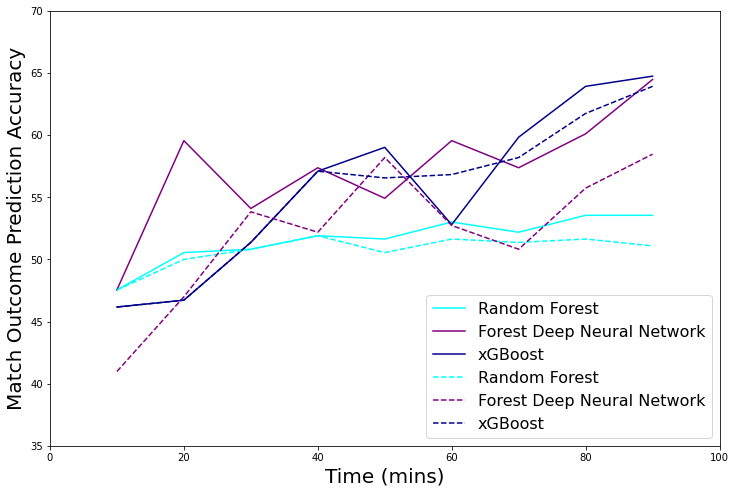

In [10]:
## Jordan's (original) match prediction outcomes
old_rf = []
old_fdnn = []
old_xb = []
accuracies = [47.54, 47.55, 46.17, 50.55, 59.56, 46.72, 50.82, 54.10, 51.37, 51.91, 57.377, 57.10, 51.64, 54.92, 59.02, 53.01, 59.56, 52.8, 52.19, 57.38, 59.84, 53.55, 60.11, 63.93, 53.55, 64.481, 64.75]
for i in range(0,27,3):
    old_rf.append(accuracies[i])
    old_fdnn.append(accuracies[i+1])
    old_xb.append(accuracies[i+2])
    
minutes = [10,20,30,40,50,60,70,80,90]

plt.figure(figsize = (12,8))
plt.plot(minutes,old_rf, label = 'Random Forest', color = 'cyan')#color = (0.387,0.18,0.434))
plt.plot(minutes,old_fdnn, label = 'Forest Deep Neural Network',color = 'purple') #color = (0.226,0.279,0.495))
plt.plot(minutes,old_xb, label = 'xGBoost', color = 'darkblue')#color = (0.222,0.391,0.387))


## Jordan's fixed match prediction outcomes
rf = []
fdnn = []
xb = []
accuracies = [47.54, 40.98, 46.17, 50.00,46.99,46.72,50.82,53.83,51.37,51.91,52.19,57.10, 50.55, 58.20,56.56,51.64,52.73,56.83,51.37,50.82,58.20,51.64,55.74,61.75,51.09,58.47,63.93]
for i in range(0,27,3):
    rf.append(accuracies[i])
    fdnn.append(accuracies[i+1])
    xb.append(accuracies[i+2])
    
minutes = [10,20,30,40,50,60,70,80,90]

plt.plot(minutes,rf, label = 'Random Forest', color = 'cyan', linestyle = 'dashed')#color = (0.387,0.18,0.434))
plt.plot(minutes,fdnn, label = 'Forest Deep Neural Network',color = 'purple', linestyle = 'dashed') #color = (0.226,0.279,0.495))
plt.plot(minutes,xb, label = 'xGBoost', color = 'darkblue', linestyle = 'dashed')#color = (0.222,0.391,0.387))
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)', fontsize = 20)
plt.ylabel('Match Outcome Prediction Accuracy', fontsize = 20)
plt.legend(fontsize = 16)

In [11]:
news = [rf,fdnn,xb]
olds= [old_rf, old_fdnn, old_xb]
names = ['RF','FDNN','XGBoost']

for i in range(len(news)):
    new_alg = news[i]
    old_alg = olds[i]
    
    diff = 0
    for j in range(len(new_alg)):
        diff += new_alg[j]-old_alg[j]
    
    diff = diff/(len(new_alg))
    
    print(names[i],diff)

RF -0.9111111111111099
FDNN -5.009777777777779
XGBoost -0.34111111111111114


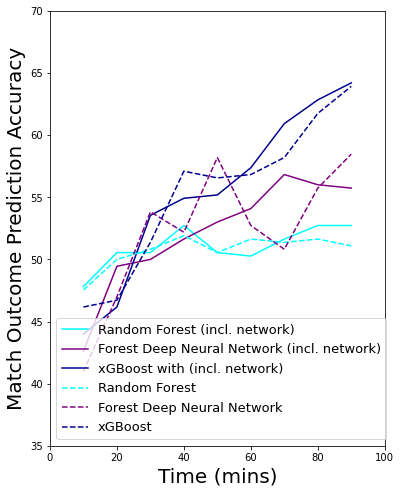

In [12]:
# Updated with network metrics

rf = [47.81,50.55,50.55,52.73,50.55,50.27,51.64,52.73,52.73]
fdnn = [42.62,49.45,50.00,51.64,53.01,54.09,56.83,56.01,55.74]
xg = [43.99,46.17,53.55,54.92,55.19,57.38,60.93,62.84,64.21]

old_rf = []
old_fdnn = []
old_xb = []
accuracies = [47.54, 40.98, 46.17, 50.00,46.99,46.72,50.82,53.83,51.37,51.91,52.19,57.10, 50.55, 58.20,56.56,51.64,52.73,56.83,51.37,50.82,58.20,51.64,55.74,61.75,51.09,58.47,63.93]
for i in range(0,27,3):
    old_rf.append(accuracies[i])
    old_fdnn.append(accuracies[i+1])
    old_xb.append(accuracies[i+2])


plt.figure(figsize = (6,8))
plt.plot(minutes,rf, label = 'Random Forest (incl. network)', color = 'cyan')#color = (0.387,0.18,0.434))
plt.plot(minutes,fdnn, label = 'Forest Deep Neural Network (incl. network)',color = 'purple') #color = (0.226,0.279,0.495))
plt.plot(minutes,xg, label = 'xGBoost with (incl. network)', color = 'darkblue')#color = (0.222,0.391,0.387))
plt.plot(minutes,old_rf, label = 'Random Forest', color = 'cyan', linestyle = 'dashed')#color = (0.387,0.18,0.434))
plt.plot(minutes,old_fdnn, label = 'Forest Deep Neural Network',color = 'purple', linestyle = 'dashed') #color = (0.226,0.279,0.495))
plt.plot(minutes,old_xb, label = 'xGBoost', color = 'darkblue', linestyle = 'dashed')#color = (0.222,0.391,0.387))
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)', fontsize = 20)
plt.ylabel('Match Outcome Prediction Accuracy', fontsize = 20)
plt.legend(fontsize = 13)

In [13]:
news = [rf,fdnn,xg]
olds= [old_rf, old_fdnn, old_xb]
names = ['RF','FDNN','XGBoost']

for i in range(len(news)):
    new_alg = news[i]
    old_alg = olds[i]
    
    diff = 0
    for j in range(len(new_alg)):
        diff += new_alg[j]-old_alg[j]
    
    diff = diff/(len(new_alg))
    
    print(names[i],diff)

RF 0.33333333333333254
FDNN -0.062222222222221686
XGBoost 0.0611111111111108


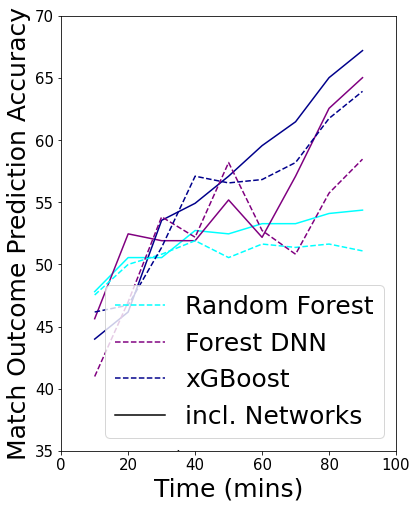

In [83]:
# Hopefully final network metrics one

rf = [47.81,50.55,50.55,52.73, 52.46, 53.28, 53.28, 54.10, 54.37]
fdnn = [45.63,52.46,51.91,51.91, 55.19, 52.18, 57.10, 62.56, 65.03]
xg = [43.99,46.17,53.55,54.92, 57.10, 59.56, 61.48, 65.03, 67.21]

old_rf = []
old_fdnn = []
old_xb = []
accuracies = [47.54, 40.98, 46.17, 50.00,46.99,46.72,50.82,53.83,51.37,51.91,52.19,57.10, 50.55, 58.20,56.56,51.64,52.73,56.83,51.37,50.82,58.20,51.64,55.74,61.75,51.09,58.47,63.93]
for i in range(0,27,3):
    old_rf.append(accuracies[i])
    old_fdnn.append(accuracies[i+1])
    old_xb.append(accuracies[i+2])


plt.figure(figsize = (6,8))
#plt.plot(minutes,rf, label = 'Random Forest (incl. network)', color = 'cyan')#color = (0.387,0.18,0.434))
#plt.plot(minutes,fdnn, label = 'Forest DNN (incl. network)',color = 'purple') #color = (0.226,0.279,0.495))
#plt.plot(minutes,xg, label = 'xGBoost (incl. network)', color = 'darkblue')#color = (0.222,0.391,0.387))
plt.plot(minutes,rf, color = 'cyan')#color = (0.387,0.18,0.434))
plt.plot(minutes,fdnn, color = 'purple') #color = (0.226,0.279,0.495))
plt.plot(minutes,xg, color = 'darkblue')#color = (0.222,0.391,0.387))
plt.plot(minutes,old_rf, label = 'Random Forest', color = 'cyan', linestyle = 'dashed')#color = (0.387,0.18,0.434))
plt.plot(minutes,old_fdnn, label = 'Forest DNN',color = 'purple', linestyle = 'dashed') #color = (0.226,0.279,0.495))
plt.plot(minutes,old_xb, label = 'xGBoost', color = 'darkblue', linestyle = 'dashed')#color = (0.222,0.391,0.387))
plt.plot([35,0],[35,0], label = 'incl. Networks', color = 'black')
plt.xlim(0,100)
plt.ylim(35,70)
plt.xlabel('Time (mins)', fontsize = 25)
plt.ylabel('Match Outcome Prediction Accuracy', fontsize = 25)
plt.legend(fontsize = 25)

In [17]:
news = [rf,fdnn,xg]
olds= [old_rf, old_fdnn, old_xb]
names = ['RF','FDNN','XGBoost']

for i in range(len(news)):
    new_alg = news[i]
    old_alg = olds[i]
    
    diff = 0
    for j in range(len(new_alg)):
        diff += new_alg[j]-old_alg[j]
    
    diff = diff/(len(new_alg))
    
    print(names[i],diff)

RF 1.3966666666666667
FDNN 2.668888888888889
XGBoost 1.1533333333333329


In [15]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')
Teams = pd.read_json('Teams.json')

In [16]:
Teams.loc[Teams['wyId'] == 675]

,city,name,wyId,officialName,area,type
14,Madrid,Real Madrid,675,Real Madrid Club de F\u00fatbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
